# Application of (k)da-PLS for domain adaptation
## Dr. Ramin Nikzad-Langerodi
### Bottleneck Analytics GmbH
info@bottleneck-analytics.com

___
First we load some modules that we will be using including the di-PLS class.

In [1]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from diPLSlib.models import DIPLS as dipls
from diPLSlib.models import KDAPLS as kdapls
from diPLSlib.utils import misc as fct
from sklearn.model_selection import GridSearchCV, cross_val_predict

### Simulated Data

Let's create some simulated *Source* and *Target domain* data sets with N=50 and p=100 samples and variables, respectively. 

In [2]:
n = 50  # Number of samples
p = 100 # Number of variables

To this end, we define 3 Gaussians where the first will correspond to the (*analyte*) signal that we will try to model and the other two will correspond to disturbing signals (*interferents*). 

The Source domain data set will contain only analyte information and contributions from **one** of the two interferents.

In [3]:
np.random.seed(10)

# Source domain (analyte + 1 interferent)
S1 = fct.gengaus(p, 50, 15, 8, 0)  # Analyte signal
S2 = fct.gengaus(p, 70, 10, 10, 0) # Interferent 1 signal
S = np.vstack([S1,S2])

# Analyte and interferent concentrations
Cs = 10*np.random.rand(n,2)

# Spectra
Xs = Cs@S

In the Target domain we will have contributions from the analyte and **both** interferents.

In [4]:
# Target domain (Analyte + 2 Interferents)
S1 = fct.gengaus(p, 50, 15, 8, 0)  # Analyte signal
S2 = fct.gengaus(p, 70, 10, 10, 0) # Interferent 1 signal
S3 = fct.gengaus(p, 30, 10, 10, 0) # Interferent 2 signal
S = np.vstack([S1,S2,S3])

# Analyte and interferent concentrations
Ct = 10*np.random.rand(n,3)

# Spectra
Xt = Ct@S

Let's plot the pure signals of analyte and interferents as well as the simulated data sets.

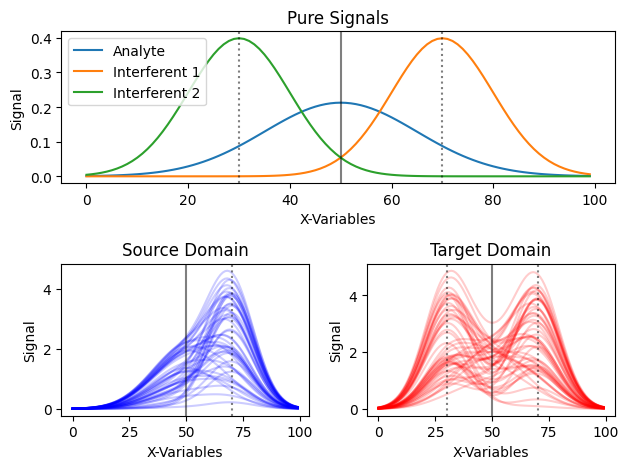

In [5]:
# Plot pure signals
plt.figure()

plt.subplot(211)
plt.plot(S1)
plt.plot(S2)
plt.plot(S3)
plt.legend(['Analyte','Interferent 1','Interferent 2'])
plt.title('Pure Signals')
plt.xlabel('X-Variables')
plt.ylabel('Signal')
plt.axvline(x=50,linestyle='-',color='k',alpha=0.5)
plt.axvline(x=70,linestyle=':',color='k',alpha=0.5)
plt.axvline(x=30,linestyle=':',color='k',alpha=0.5)

# Source domain
plt.subplot(223)
plt.plot(Xs.T, 'b', alpha=0.2)
plt.title('Source Domain')
plt.xlabel('X-Variables')
plt.ylabel('Signal')
plt.axvline(x=50,linestyle='-',color='k',alpha=0.5)
plt.axvline(x=70,linestyle=':',color='k',alpha=0.5)

# Target domain
plt.subplot(224)
plt.plot(Xt.T, 'r', alpha=0.2)
plt.title('Target Domain')
plt.xlabel('X-Variables')
plt.ylabel('Signal')
plt.axvline(x=50,linestyle='-',color='k',alpha=0.5)
plt.axvline(x=70,linestyle=':',color='k',alpha=0.5)
plt.axvline(x=30,linestyle=':',color='k',alpha=0.5)
plt.tight_layout()

### di-PLS vs. (k)da-PLS
We will now fit unsupervised di- and (k)da-PLS models and compare their performance on the target domain. We start by utilizing the primal version of da-PLS followed by a discussion on the kernelized version. 

Note that di-PLS minimizes the covariance difference between source and target domain, thus making the implicit assumption that the corresponding data sets follow a normal distribution. da-PLS on the other hand uses a non-parametric approach to align source and target distributions in latent space and does not make any assumptions about the underlying data distributions.

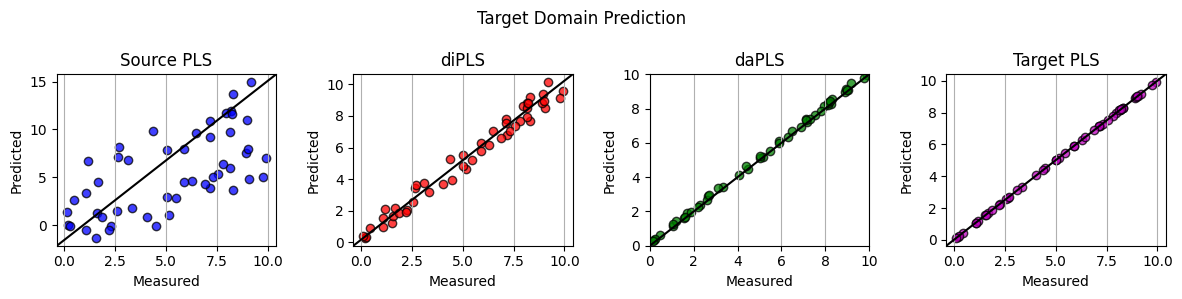

In [6]:
plt.figure(figsize=(12, 3))

# Source PLS Model
plt.subplot(141)

y = np.expand_dims(Cs[:, 0],1)
m = dipls(A=2, l=0)
l = [0] # No regularization
m.fit(Xs, y, Xs, Xt)
b_pls = m.b_

# Predict analyte in the target domain
yhat_pls = m.predict(Xt)
plt.scatter(Ct[:, 0], yhat_pls, color='b', edgecolor='k',alpha=0.75)
ax = plt.gca()
ax.plot([0, 1], [0, 1], 'k', transform=ax.transAxes)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.grid(axis='x')
plt.title('Source PLS')

# diPLS Model
plt.subplot(142)

m_di = dipls(A=2, l=100000)
m_di.fit(Xs, y, Xs, Xt)
b_dipls = m_di.b_

# Predict analyte in the target domain
yhat_dipls = m_di.predict(Xt)
plt.scatter(Ct[:, 0], yhat_dipls, color='r', edgecolor='k',alpha=0.75)
ax = plt.gca()
ax.plot([0, 1], [0, 1], 'k', transform=ax.transAxes)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.grid(axis='x')
plt.title('diPLS')

# KDA-PLS Model
plt.subplot(143)

m_kda = kdapls(A=2, l=1000, target_domain=0, kernel_params={'type': 'primal'})
m_kda.fit(Xs, y, Xs, Xt)
b_kda = m_kda.coef_

# Predict analyte in the target domain
yhat_kda = m_kda.predict(Xt)
plt.scatter(Ct[:, 0], yhat_kda, color='g', edgecolor='k',alpha=0.75)
ax = plt.gca()
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.plot([0, 1], [0, 1], 'k', transform=ax.transAxes)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.grid(axis='x')
plt.title('daPLS')

# Target PLS Model
plt.subplot(144)

y = np.expand_dims(Ct[:, 0], 1)
m_target = dipls(A=3, l=0)
m_target.fit(Xt, y, Xs, Xt)
b_target = m_target.b_

# Predict analyte in the target domain
yhat_target = m_target.predict(Xt)
plt.scatter(Ct[:, 0], yhat_target, color='m', edgecolor='k',alpha=0.75)
ax = plt.gca()
ax.plot([0, 1], [0, 1], 'k', transform=ax.transAxes)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.grid(axis='x')
plt.title('Target PLS')

plt.suptitle('Target Domain Prediction')
plt.tight_layout()

We can see that in this case the da-PLS model clearly outperforms the di-PLS model. To see why, we will next inspect the regression coefficients corresponding to the 4 models.

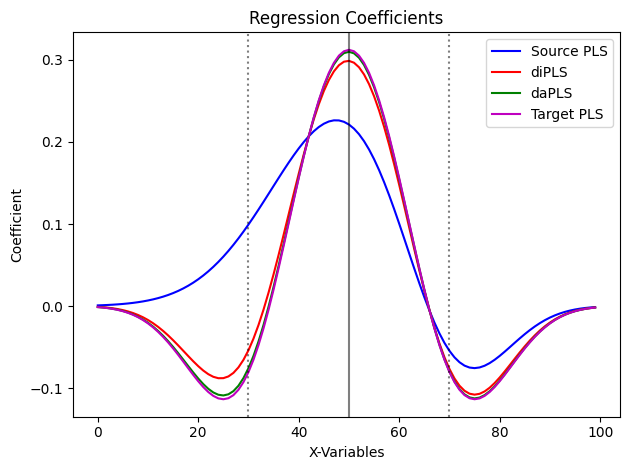

In [7]:
# Plot regression coefficients
plt.figure()

plt.plot(b_pls, 'b')
plt.plot(b_dipls, 'r')
plt.plot(b_kda, 'g')
plt.plot(b_target, 'm')
plt.legend(['Source PLS','diPLS','daPLS','Target PLS'])
plt.title('Regression Coefficients')
plt.xlabel('X-Variables')
plt.ylabel('Coefficient')
plt.axvline(x=50,linestyle='-',color='k',alpha=0.5)
plt.axvline(x=70,linestyle=':',color='k',alpha=0.5)
plt.axvline(x=30,linestyle=':',color='k',alpha=0.5)
plt.tight_layout()

We can see that the regression coefficients of the da-PLS model (green) resemble the target domain PLS model coeffcients (magenta) more closely than the di-PLS model (blue).

### Melamine Data

In [8]:
# Load and read the data
url = "https://github.com/RNL1/Melamine-Dataset/blob/master/Melamine_Dataset.pkl?raw=true"
data = pd.read_pickle(url)

wn1 = data['wn1']
wn2 = data['wn2']
w = np.hstack((wn1, wn2))

Xs = np.hstack((data['R862']['X1'], data['R862']['X2']))
Xt = np.hstack((data['R861']['X1'], data['R861']['X2']))

ys = data['R862']['Y']
yt = data['R861']['Y']

In [9]:
# Tune the number of LVs and Kernel parameters
param_grid = {'A': np.arange(1, 20),
              'kernel_params': [{'type': 'rbf', 'gamma': 1e-3},
                                {'type': 'linear'},
                                {'type': 'primal'}]}

# Intialize KDAPLS model 
m_kdapls = kdapls(target_domain=0)

# Tune the number of LVs with the root mean squared error as the scoring metric
grid_search = GridSearchCV(m_kdapls, param_grid, cv=5, scoring= 'neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(Xs, ys)

# Print the best parameters and best score for each scorer
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'A': np.int64(12), 'kernel_params': {'type': 'primal'}}


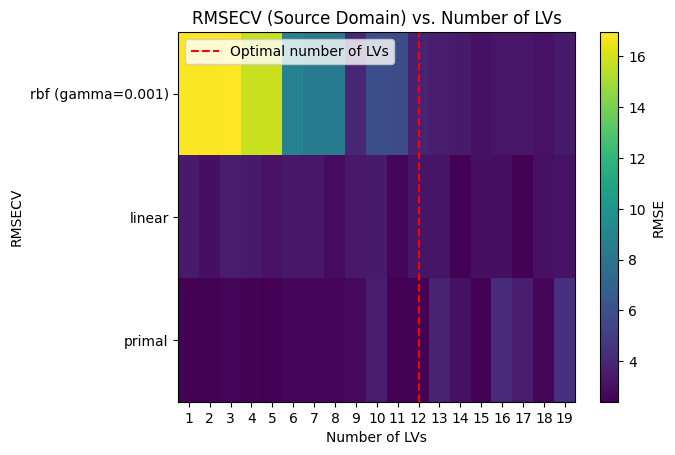

In [10]:
# Plot MSE vs number of LVs
opt_A = grid_search.best_params_['A']-1
rmse = -grid_search.cv_results_['mean_test_score']
rmse_std = grid_search.cv_results_['std_test_score']
#plt.errorbar(param_grid['A'], rmse, yerr=rmse_std, fmt='-o', mec='k', label='CV Error')
rmse_2d = rmse.reshape(len(param_grid["kernel_params"]), len(param_grid["A"]))
plt.imshow(rmse_2d, cmap="viridis", aspect="auto")
plt.colorbar(label="RMSE")
plt.xticks(np.arange(len(param_grid["A"])), param_grid["A"])
kernel_labels = [
    f"{kp['type']} (gamma={kp.get('gamma','-')})" 
    if 'gamma' in kp else kp['type'] 
    for kp in param_grid["kernel_params"]
]
plt.yticks(np.arange(len(kernel_labels)), kernel_labels)
plt.xlabel("Number of LVs")
plt.ylabel("Kernel Parameters")
plt.title("RMSE Heatmap")
plt.gca().axvline(opt_A, color='r', linestyle='--', label='Optimal number of LVs')
plt.xlabel('Number of LVs')
plt.ylabel('RMSECV')
plt.title('RMSECV (Source Domain) vs. Number of LVs')
plt.legend()
plt.show()

Best parameters found:  {'l': np.float64(1000.0)}


<ErrorbarContainer object of 3 artists>

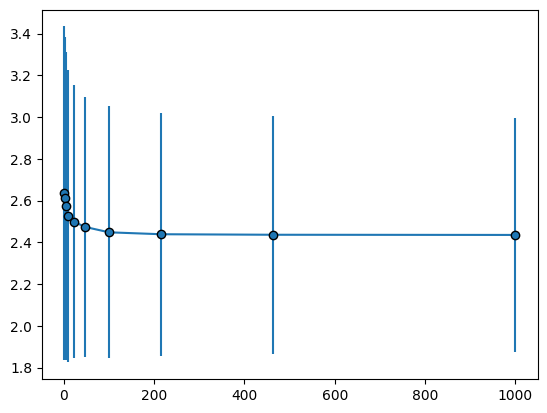

In [11]:
# Tune the the regularization parameter
param_grid = {'l': np.logspace(0, 3, 10)}

# Intialize KDAPLS model 
m_kdapls = kdapls(target_domain=0, A=12, kernel_params={'type': 'primal'})

# Tune the number of LVs with the root mean squared error as the scoring metric
grid_search = GridSearchCV(m_kdapls, param_grid, cv=5, scoring= 'neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(Xs, ys, **{'xs': Xs, 'xt': Xt})

# Print the best parameters and best score for each scorer
print("Best parameters found: ", grid_search.best_params_)

# Plot MSE vs number of l
rmse = -grid_search.cv_results_['mean_test_score']
rmse_std = grid_search.cv_results_['std_test_score']
plt.errorbar(param_grid['l'], rmse, yerr=rmse_std, fmt='-o', mec='k', label='CV Error')

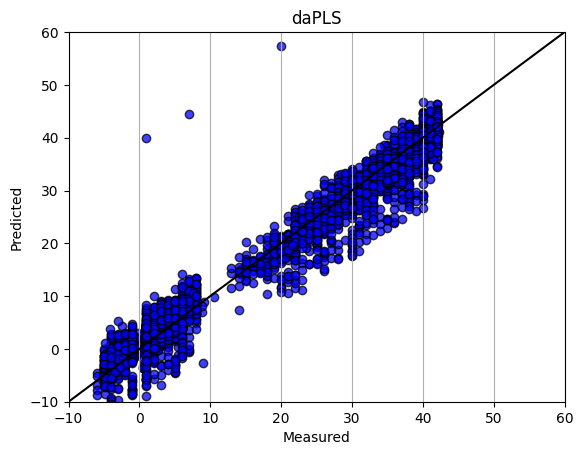

RMSEP: 3.39


In [12]:
m_kdapls = kdapls(target_domain=0, A=12, l=1000, kernel_params={'type': 'primal'})

# Fit the model
m_kdapls.fit(Xs, ys, **{'xs': Xs, 'xt': Xt})

# Predict the target domain
yhat = m_kdapls.predict(Xt)

# Plot the predicted vs measured values
plt.scatter(yt, yhat, color='b', edgecolor='k', alpha=0.75)
ax = plt.gca()
ax.set_xlim([-10, 60])
ax.set_ylim([-10, 60])
ax.plot([0, 1], [0, 1], 'k', transform=ax.transAxes)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.grid(axis='x')
plt.title('daPLS')
plt.show()

from diPLSlib.utils.misc import rmse as r_mse
print(f"RMSEP: {r_mse(yhat.T, yt.T):.2f}")

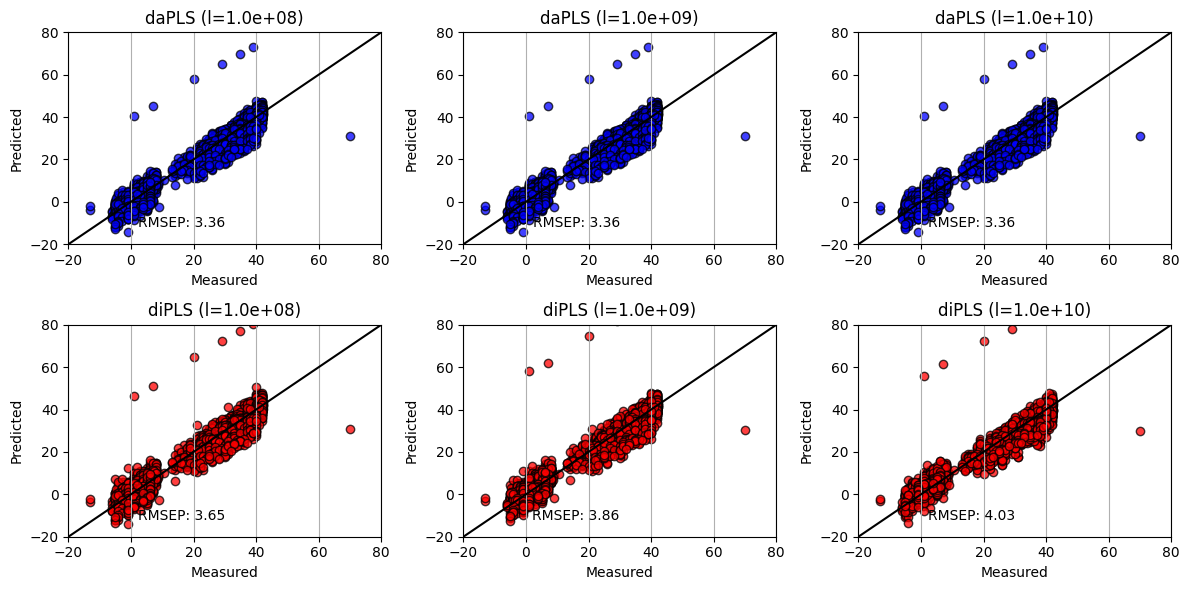

In [13]:
# Regularization params diPLS and daPLS
l_da = [1e8, 1e9, 1e10]
l_di = [1e8, 1e9, 1e10]

# Regression coefficients
b_da = {}
b_di = {}

i = 0
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(2, 3, i+1)
    m_da = kdapls(A=12, l=l_da[i], target_domain=0, kernel_params={'type': 'primal'})
    m_da.fit(Xs, ys, Xs, Xt)
    yhat_da = m_da.predict(Xt)
    plt.scatter(yt, yhat_da, color='b', edgecolor='k', alpha=0.75)
    ax = plt.gca()
    ax.set_xlim([-20, 80])
    ax.set_ylim([-20, 80])
    ax.plot([0, 1], [0, 1], 'k', transform=ax.transAxes)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.grid(axis='x')
    plt.title(f"daPLS (l={l_da[i]:.1e})")
    plt.text(0.5, 0.1, f"RMSEP: {r_mse(yhat_da.T, yt.T):.2f}", ha='right', va='center', transform=ax.transAxes)
    b_da[l_da[i]] = m_da.coef_

    plt.subplot(2, 3, i+4)
    m_di = dipls(A=12, l=l_di[i])
    m_di.fit(Xs, ys, Xs, Xt)
    yhat_di = m_di.predict(Xt)
    plt.scatter(yt, yhat_di, color='r', edgecolor='k', alpha=0.75)
    ax = plt.gca()
    ax.set_xlim([-20, 80])
    ax.set_ylim([-20, 80])
    ax.plot([0, 1], [0, 1], 'k', transform=ax.transAxes)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.grid(axis='x')
    plt.title(f"diPLS (l={l_di[i]:.1e})")
    plt.text(0.5, 0.1, f"RMSEP: {r_mse(yhat_di.T, yt.T):.2f}", ha='right', va='center', transform=ax.transAxes)
    b_di[l_di[i]] = m_di.b_

plt.tight_layout()

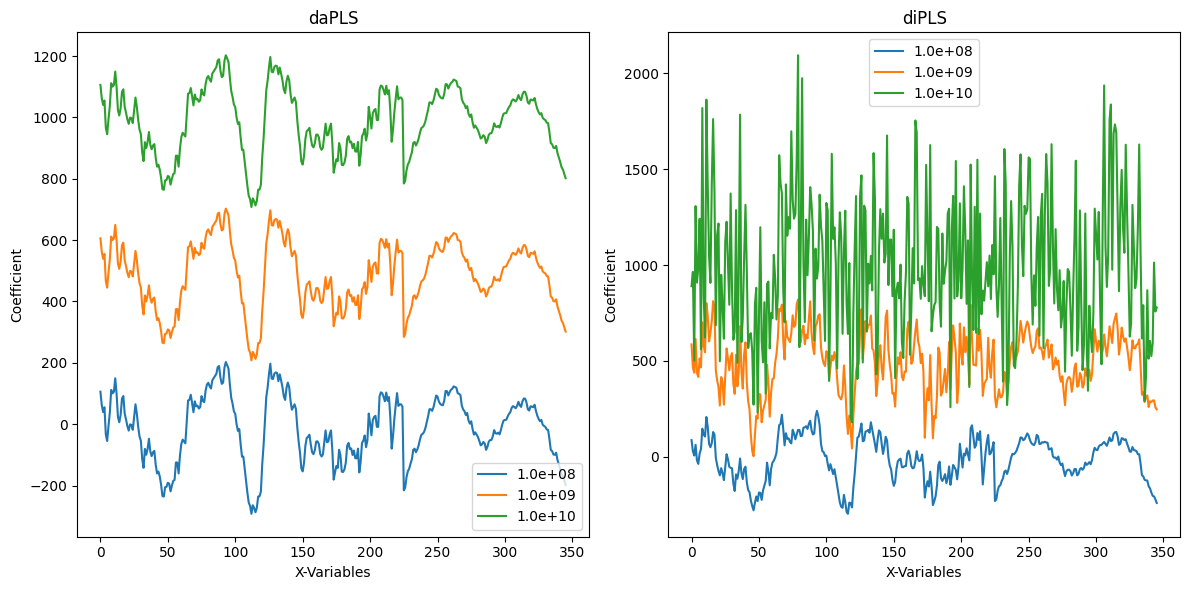

In [14]:
# Plot regression coefficients
plt.figure(figsize=(12, 6))
plt.subplot(121)
offset = 0
for i, key in enumerate(b_da):
    plt.plot(b_da[key] + offset, label=f"{key:.1e}")
    offset += 500  # Adjust the offset value as needed
plt.legend([f"{key:.1e}" for key in b_da.keys()])
plt.title('daPLS')
plt.xlabel('X-Variables')
plt.ylabel('Coefficient')

# Plot diPLS coefficients with offset
plt.subplot(122)
offset = 0
for i, key in enumerate(b_di):
    plt.plot(b_di[key] + offset, label=f"{key:.1e}")
    offset += 500  # Adjust the offset value as needed
plt.legend([f"{key:.1e}" for key in b_di.keys()])
plt.title('diPLS')
plt.xlabel('X-Variables')
plt.ylabel('Coefficient')

plt.tight_layout()

### Multiple Target Domains

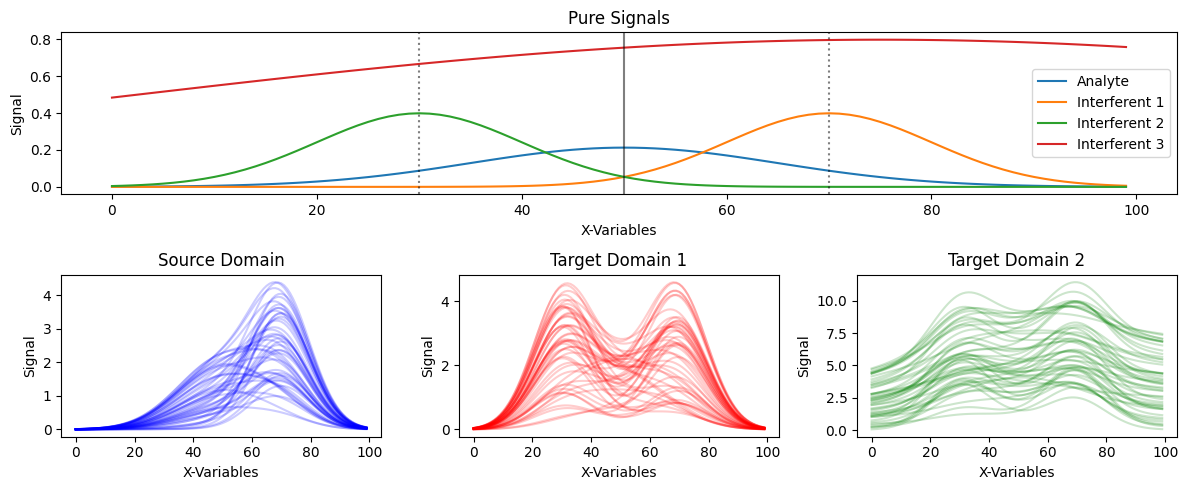

In [28]:
### Source domain (Analyte + 1 Interferent)
n = 50  # Number of samples
p = 100 # Number of variables

# Generate signals
S1 = fct.gengaus(p, 50, 15, 8, 0)  # Analyte
S2 = fct.gengaus(p, 70, 10, 10, 0) # Interferent
S = np.vstack([S1,S2])

# Analyte concentrations
Cs = 10*np.random.rand(n,S.shape[0])

# Spectra
X = Cs@S

# Random noise
noise = 0.005*np.random.rand(n,p)

# Source domain spectra plus noise
Xs = X# + noise

# Target domain 1 (Analyte + 2 Interferents)
S1 = fct.gengaus(p, 50, 15, 8, 0)  # Analyte
S2 = fct.gengaus(p, 70, 10, 10, 0) # Interferent 1
S3 = fct.gengaus(p, 30, 10, 10, 0) # Interferent 2
S = np.vstack([S1,S2,S3])

# Analyte concentrations
Ct1 = 10*np.random.rand(n,S.shape[0])

# Spectra
X = Ct1@S

# Random noise
noise = 0.005*np.random.rand(n,p)

# Target domain spectra plus noise
Xt1 = X# + noise

# Target domain 2 (Analyte + 3 Interferents)
S1 = fct.gengaus(p, 50, 15, 8, 0)  # Analyte
S2 = fct.gengaus(p, 70, 10, 10, 0) # Interferent 1
S3 = fct.gengaus(p, 30, 10, 10, 0) # Interferent 2
S4 = fct.gengaus(p, 75, 75, 150, 0) # Interferent 3
S = np.vstack([S1, S2, S3, S4])

# Analyte concentrations
Ct2 = 10*np.random.rand(n,S.shape[0])

# Spectra
X = Ct2@S

# Random noise
noise = 0.005*np.random.rand(n,p)

# Target domain spectra plus noise
Xt2 = X# + noise

plt.figure(figsize=(12,5))
plt.subplot(211)
plt.plot(S1)
plt.plot(S2)
plt.plot(S3)
plt.plot(S4)
plt.legend(['Analyte','Interferent 1','Interferent 2', 'Interferent 3'])
plt.title('Pure Signals')
plt.xlabel('X-Variables')
plt.ylabel('Signal')
plt.axvline(x=50,linestyle='-',color='k',alpha=0.5)
plt.axvline(x=70,linestyle=':',color='k',alpha=0.5)
plt.axvline(x=30,linestyle=':',color='k',alpha=0.5)


plt.subplot(234)
plt.plot(Xs.T, 'b', alpha=0.2)
plt.title('Source Domain')
plt.xlabel('X-Variables')
plt.ylabel('Signal')

plt.subplot(235)
plt.plot(Xt1.T, 'r', alpha=0.2)
plt.title('Target Domain 1')
plt.xlabel('X-Variables')
plt.ylabel('Signal')

plt.subplot(236)
plt.plot(Xt2.T, 'g', alpha=0.2)
plt.title('Target Domain 2')
plt.xlabel('X-Variables')
plt.ylabel('Signal')
plt.tight_layout()
plt.show()

RMSEP Target Domain 1: 0.35
RMSEP Target Domain 2: 0.36


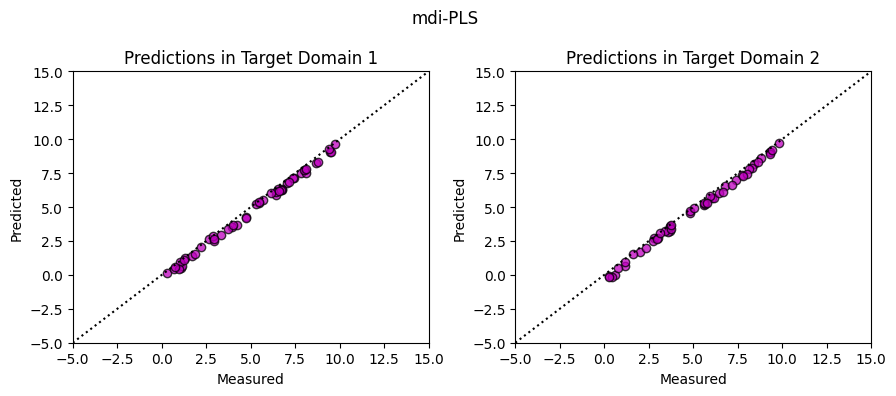

In [29]:
# Preliminaries
nr_comp = 2                         # Number of components
l = 1e9   # Regularization parameter                           
target_domains = [Xt1, Xt2]         # Target domains
ys = np.expand_dims(Cs[:, 0],1)     # Source domain concentrations
yt1 = np.expand_dims(Ct1[:, 0],1)   # Target domain 1 concentrations
yt2 = np.expand_dims(Ct2[:, 0],1)   # Target domain 2 concentrations

# daPLS model
m_kdapls = kdapls(A=nr_comp, l=l, target_domain=0, kernel_params={'type': 'primal'})
m_kdapls.fit(Xs, ys, Xs, target_domains)
b_dapls = m_kdapls.coef_
yhat_diplsT1 = m_kdapls.predict(Xt1)
yhat_diplsT2 = m_kdapls.predict(Xt2)

error_diplsT1 = fct.rmse(yt1, yhat_diplsT1)
error_diplsT2 = fct.rmse(yt2, yhat_diplsT2)
print(f"RMSEP Target Domain 1: {error_diplsT1:.2f}")
print(f"RMSEP Target Domain 2: {error_diplsT2:.2f}")

min_ = -5
max_ = 15

# Plot
plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(yt1, yhat_diplsT1, color='m', edgecolor='k',alpha=0.75)
plt.plot([min_,max_], [min_,max_], color='k', linestyle=":")
plt.xlim([min_,max_])
plt.ylim([min_,max_])
plt.title('Predictions in Target Domain 1')
plt.xlabel('Measured')
plt.ylabel('Predicted')

plt.subplot(122)
plt.scatter(yt2, yhat_diplsT2, color='m', edgecolor='k',alpha=0.75)
plt.plot([min_,max_], [min_,max_], color='k', linestyle=":")
plt.xlim([min_,max_])
plt.ylim([min_,max_])
plt.title('Predictions in Target Domain 2')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.suptitle('mdi-PLS')
plt.tight_layout()